In [1]:
from utils import cp_detector as cpd
from utils import data_generation as gen
from utils import statistic_calculation as stat
from utils import threshold_calculation as th

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [75]:
dataset_parameters = {
    "dataset_size": 500,
    "seq_len": 100,
    "d": 50,
    "p": 10,
    "distribution": "normal",
    "k": 1,
    "cp": 50,
    "nu": 3,
    "seed": 124
}

cp_parameters = {
    "alpha": 0.05,
    "scan": False,
    "data_based": False,
    "ln": False
}

In [76]:
data_with_cp, data_without_cp, t_cp_idxs = gen.generate_data(**dataset_parameters)

In [77]:
layer_norm = nn.LayerNorm(dataset_parameters["d"], elementwise_affine=True).float()
# data_with_cp = torch.from_numpy(data_with_cp).float()
# data_without_cp = torch.from_numpy(data_without_cp).float()


# data_with_cp_ln = (
#     layer_norm(data_with_cp)
# )
# data_without_cp_ln = (
#     layer_norm(data_without_cp)
# )

data_with_cp_ln = (
    layer_norm(torch.from_numpy(data_with_cp).float()).detach().numpy()
)
data_without_cp_ln = (
    layer_norm(torch.from_numpy(data_without_cp).float()).detach().numpy()
)

In [103]:
from utils import knn_divergence as kl
import warnings
warnings.filterwarnings("ignore")

In [111]:
print('Without LN, F||G')
print('naive', kl.naive_estimator(data_without_cp[0], data_with_cp[0], k=20))
print('scipy', kl.scipy_estimator(data_without_cp[0], data_with_cp[0], k=20))
print('skl_est', kl.skl_estimator(data_without_cp[0], data_with_cp[0], k=20))
print('skl_eff', kl.skl_efficient(data_without_cp[0], data_with_cp[0], k=20))

loss = nn.KLDivLoss(log_target=False, reduction='mean')
print('torch', loss(torch.from_numpy(data_without_cp[0]), torch.from_numpy(data_with_cp[0])).detach().numpy())

Without LN, F||G
naive 0.9709231107222958
scipy 0.9709231107222958
skl_est 0.9709231107222952
skl_eff 0.9709231107222958
torch -0.4629207183826042


In [114]:
print('With LN, F||G')
print('naive', kl.naive_estimator(data_without_cp_ln[0], data_with_cp_ln[0], k=20))
print('scipy', kl.scipy_estimator(data_without_cp_ln[0], data_with_cp_ln[0], k=20))
print('skl_est', kl.skl_estimator(data_without_cp_ln[0], data_with_cp_ln[0], k=20))
print('skl_eff', kl.skl_efficient(data_without_cp_ln[0], data_with_cp_ln[0], k=20))
loss = nn.KLDivLoss(log_target=False, reduction='mean')
print('torch', loss(torch.from_numpy(data_without_cp_ln[0]), torch.from_numpy(data_with_cp_ln[0])).detach().numpy())

With LN, F||G
naive -0.08760431941757002
scipy -0.08760423375617118
skl_est -0.08760422686750285
skl_eff -0.08760423375617013
torch -0.45047098


In [118]:
print('Without LN, G||F')
print('naive', kl.naive_estimator(data_with_cp[0], data_without_cp[0], k=20))
print('scipy', kl.scipy_estimator(data_with_cp[0], data_without_cp[0], k=20))
print('skl_est', kl.skl_estimator(data_with_cp[0], data_without_cp[0], k=20))
print('skl_eff', kl.skl_efficient(data_with_cp[0], data_without_cp[0], k=20))
print('torch', loss(torch.from_numpy(data_with_cp[0]), torch.from_numpy(data_without_cp[0])).detach().numpy())

Without LN, G||F
naive 0.07242428038760351
scipy 0.07242428038760429
skl_est 0.07242428038760426
skl_eff 0.07242428038760379
torch -0.5160398394872967


In [120]:
print('With LN, G||F')
print('naive', kl.naive_estimator(data_with_cp_ln[0], data_without_cp_ln[0], k=20))
print('scipy', kl.scipy_estimator(data_with_cp_ln[0], data_without_cp_ln[0], k=20))
print('skl_est', kl.skl_estimator(data_with_cp_ln[0], data_without_cp_ln[0], k=20))
print('skl_eff', kl.skl_efficient(data_with_cp_ln[0], data_without_cp_ln[0], k=20))
print('torch', loss(torch.from_numpy(data_with_cp_ln[0]), torch.from_numpy(data_without_cp_ln[0])).detach().numpy())

With LN, G||F
naive 1.1703446808805702
scipy 1.1703447548257033
skl_est 1.1703450119657455
skl_eff 1.1703447548257044
torch -0.45826122


In [55]:
def kl_divergence(mu1, mu2, sigma_1, sigma_2):
	sigma_diag_1 = np.eye(sigma_1.shape[0]) * sigma_1
	sigma_diag_2 = np.eye(sigma_2.shape[0]) * sigma_2

	sigma_diag_2_inv = np.linalg.inv(sigma_diag_2)

	kl = 0.5 * (np.log(np.linalg.det(sigma_diag_2) / np.linalg.det(sigma_diag_2))
				- mu1.shape[0] + np.trace(np.matmul(sigma_diag_2_inv, sigma_diag_1))
				+ np.matmul(np.matmul(np.transpose(mu2 - mu1), sigma_diag_2_inv), (mu2 - mu1))
				)

	return kl

In [60]:
d = dataset_parameters["d"]
p = dataset_parameters["p"]
k = dataset_parameters["k"]
mu_1 = np.zeros(d)
sigma_1 = np.identity(d)

mu_2 = np.zeros(d)
mu_2[-p:] = (d - 1) * k/d 

sigma_2 = ((d - 1) / d)**2 *np.identity(d)


In [61]:
kl_divergence(mu_1, mu_2, sigma_2, sigma_2)

5.0

In [67]:
d = dataset_parameters["d"]
p = dataset_parameters["p"]
k = dataset_parameters["k"]
mu_1 = np.zeros(d)
sigma_1 = np.identity(d)

mu_2 = np.zeros(d)
mu_2[-p:] = k

In [68]:
kl_divergence(mu_1, mu_2, sigma_1, sigma_1)

5.0

In [22]:
# data_with_cp_ln = (
#     layer_norm(torch.from_numpy(data_with_cp).float()).detach().numpy()
# )
# data_without_cp_ln = (
#     layer_norm(torch.from_numpy(data_without_cp).float()).detach().numpy()
# )

# data_with_cp_ln = (data_with_cp - np.expand_dims(data_with_cp.mean(2), -1))/ np.expand_dims(data_with_cp.std(2), -1)
# data_without_cp_ln = (data_without_cp - np.expand_dims(data_without_cp.mean(2), -1)) / np.expand_dims(data_without_cp.std(2), -1)

# data_with_cp_ln_mean = (data_with_cp - np.expand_dims(data_with_cp.mean(2), -1))
# data_without_cp_ln_mean = (data_without_cp - np.expand_dims(data_without_cp.mean(2), -1))

# data_with_cp_ln_std = data_with_cp / np.expand_dims(data_with_cp.std(2), -1)
# data_without_cp_ln_std = data_without_cp / np.expand_dims(data_without_cp.std(2), -1)

In [24]:
delta_sic_with, likelihood_cp_with = cpd.t_dist_data_inference(data_with_cp, dataset_parameters)
delta_sic_without, likelihood_cp_without = cpd.t_dist_data_inference(data_without_cp, dataset_parameters)

In [29]:
delta_sic_with, likelihood_cp_with = cpd.t_dist_data_inference(data_with_cp, dataset_parameters)
delta_sic_without, likelihood_cp_without = cpd.t_dist_data_inference(data_without_cp_ln, dataset_parameters)

In [25]:
delta_sic_with_ln, likelihood_cp_with_ln = cpd.t_dist_data_inference(data_with_cp_ln, dataset_parameters)
delta_sic_without_ln, likelihood_cp_without_ln = cpd.t_dist_data_inference(data_without_cp_ln, dataset_parameters)

In [26]:
w=5
min_delta = int(round(min(delta_sic_with.min(), delta_sic_without.min(), delta_sic_with_ln.min(), delta_sic_without_ln.min()), 0))
max_delta = int(round(max(delta_sic_with[:, w:-w].max(), delta_sic_without[:, w:-w].max(), delta_sic_with_ln[:, w:-w].max(), delta_sic_without_ln[:, w:-w].max()), 0))


In [30]:
fp_dict = {}
fn_dict = {}
fp_ln_dict = {}
fn_ln_dict = {}
for th in range(min_delta, max_delta):
    detected_cp = np.where(delta_sic_with.min(1) > th , -1, likelihood_cp_with.argmin(1))
    detected_false_cp = np.where(delta_sic_without.min(1) > th , -1, likelihood_cp_without.argmin(1))

    fn, fp = cpd.calculate_error(detected_cp, detected_false_cp)

    detected_cp_ln = np.where(delta_sic_with_ln.min(1) > th , -1, likelihood_cp_with_ln.argmin(1))
    detected_false_cp_ln = np.where(delta_sic_without_ln.min(1) > th , -1, likelihood_cp_without_ln.argmin(1))

    fn_ln, fp_ln = cpd.calculate_error(detected_cp_ln, detected_false_cp_ln)

    fp_dict[th] = fp
    fp_ln_dict[th] = fp_ln
    fn_dict[th] = fn
    fn_ln_dict[th] = fn_ln

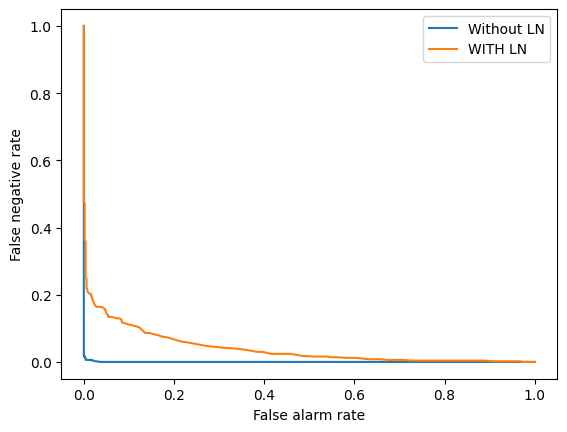

In [31]:
plt.plot(
    [value for value in fp_dict.values()],
    [value for value in fn_dict.values()],
    #"o",
    label="Without LN"
)

plt.plot(
    [value for value in fp_ln_dict.values()],
    [value for value in fn_ln_dict.values()],
    #"s",
    label="WITH LN"
)

plt.xlabel("False alarm rate")
plt.ylabel("False negative rate");
plt.legend()

In [40]:
import pickle
path = "outputs/2024-03-06/13-34-31/"

with open(path + 'alpha.pickle', 'rb') as f:
    lin_stat_alpha = pickle.load(f)
with open(path + 'beta.pickle', 'rb') as f:
    lin_stat_beta = pickle.load(f)
with open(path + 'alpha_ln.pickle', 'rb') as f:
    lin_stat_alpha_ln = pickle.load(f)
with open(path + 'beta_ln.pickle', 'rb') as f:
    lin_stat_beta_ln = pickle.load(f)

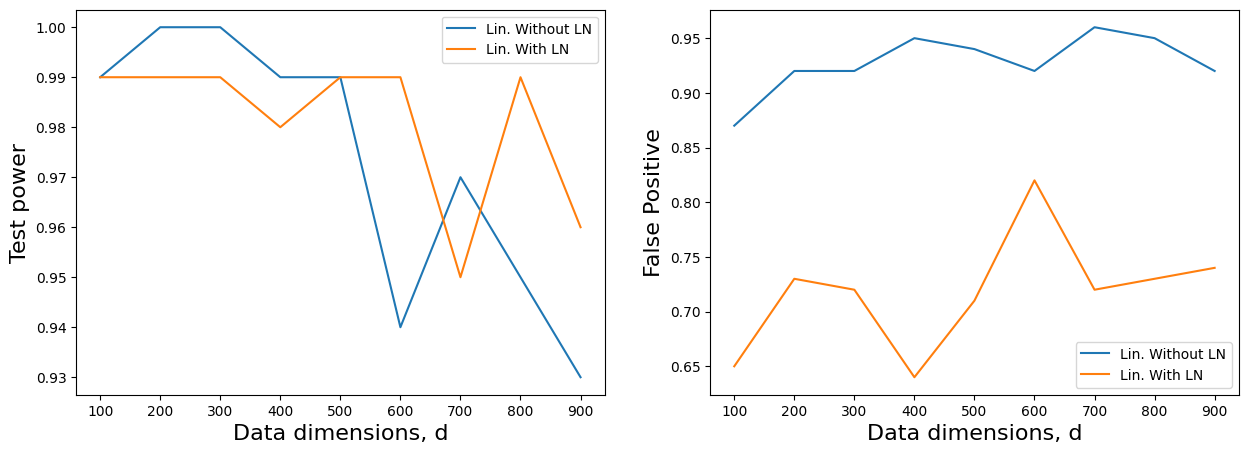

In [41]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(
    [key for key in lin_stat_beta.keys()],
    [1 - value for value in lin_stat_beta.values()],
    label="Lin. Without LN",
)

ax1.plot(
    [key for key in lin_stat_beta_ln.keys()],
    [1 - value for value in lin_stat_beta_ln.values()],
    label="Lin. With LN",
)

ax1.set_xlabel("Data dimensions, d", fontsize=16)
ax1.set_ylabel("Test power", fontsize=16)
ax1.legend()

ax2.plot(
    [key for key in lin_stat_alpha.keys()],
    [value for value in lin_stat_alpha.values()],
    label="Lin. Without LN",
)

ax2.plot(
    [key for key in lin_stat_alpha_ln.keys()],
    [value for value in lin_stat_alpha_ln.values()],
    label="Lin. With LN",
)

ax2.set_xlabel("Data dimensions, d", fontsize=16)
ax2.set_ylabel("False Positive", fontsize=16)
plt.legend()


In [ ]:
dataset_parameters["d"] = 100
dataset_parameters["p"] = 10
dataset_parameters["k"] = 1
data_with_cp, data_without_cp, t_cp_idxs = gen.generate_data(**dataset_parameters)

layer_norm = nn.LayerNorm(dataset_parameters["d"], elementwise_affine=False).float()
data_with_cp_ln = (
    layer_norm(torch.from_numpy(data_with_cp).float()).detach().numpy()
)
data_without_cp_ln = (
    layer_norm(torch.from_numpy(data_without_cp).float()).detach().numpy()
)

In [ ]:
x = data_without_cp[0, 2]
x = np.expand_dims(x, 1)

delta_theta = dataset_parameters["k"] * np.ones((dataset_parameters["p"], 1))
delta_theta = np.vstack((np.zeros((dataset_parameters["d"] - dataset_parameters["p"], 1)), delta_theta))

In [ ]:
from math import log
def generate_ln_matrix(d, beta):
    return np.identity(d) - np.ones((d, d)) * (beta / d)

def calculate_kl(x, delta_theta, beta, nu=3):
    d = x.shape[0]
    L = generate_ln_matrix(d, beta)
    L_inv = np.linalg.inv(L.T @ L)
    L_dtheta = L @ delta_theta

    log_value_ln = 1 + ((x - L_dtheta).T) @ L_inv @ (x-L_dtheta) / nu
    coef_ln = 1 + x.T @ L_inv @ x / nu
    res_ln = coef_ln * log(log_value_ln)

    log_value = 1 + (x - delta_theta).T @ (x - delta_theta) / nu
    coef = 1 + x.T @ x / nu 
    res = coef * log(log_value)

    # print(coef_ln, coef)
    print(log_value_ln, log_value)
    return res[0, 0], res_ln[0, 0]

# res_beta = {}
# for beta in np.arange(0, 10, 0.1):
#     if beta == 1 or beta == 0:
#         continue
#     res, res_ln = calculate_kl(x, delta_theta, beta)
#     res_beta[beta] = res_ln - res

In [ ]:
res, res_ln = calculate_kl(x, delta_theta, beta)

[[254.37955134]] [[226.18956537]]


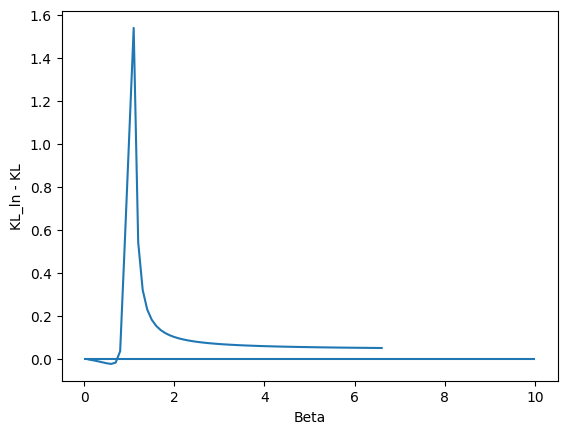

In [ ]:
plt.plot(res_beta.keys(), res_beta.values())
plt.xlabel('Beta')
plt.ylabel('KL_ln - KL')
plt.hlines(y=0, xmin=0, xmax=10)

In [ ]:
d = x.shape[0]
beta = 1.1
L = generate_ln_matrix(d, beta)
L_inv = np.linalg.inv(L.T @ L)
L_dtheta = L @ delta_theta
L_minus = np.linalg.inv(L)

In [ ]:
((x - L_dtheta).T) @ L_inv @ (x-L_dtheta) - (x - delta_theta).T @ (x - delta_theta)

array([[7.93367145]])

In [ ]:
coef_1 = - beta / (d * (beta - 1))
coef_2 = (beta - 2) / (beta - 1)
e = np.ones((d, d))

In [ ]:
coef_1 * (x.T @ (coef_2 * e @ x - 2 * e @ delta_theta))

array([[7.93367145]])

In [ ]:
10 * (beta - 1) / (beta - 2) 

-1.1111111111111123

In [ ]:
dataset_parameters["k"]

1

In [ ]:
dataset_parameters["p"]

10

In [ ]:
x.sum()

-4.152225618267513